In [1]:
import qnmfits
import numpy as np
import scipy
import corner
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import sys
from pathlib import Path

notebook_dir = Path().resolve()
sys.path.append(str(notebook_dir.parent))

notebook_dir = Path().resolve()
data_dir = notebook_dir.parent / "data"

from matplotlib.colors import to_hex
from matplotlib.lines import Line2D
from matplotlib.colors import LinearSegmentedColormap
from qnmfits.spatial_mapping_functions import * 
from bayes_qnm_GP_likelihood import *
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

In [67]:
id = "0001"
sim_main = SXS_CCE(id, lev="Lev5", radius="R2")

n_max = 7

T0 = 0
T = 100

qnm_list = [(2,2,n,1) for n in np.arange(0, n_max+1)] #+ [(3,2,0,1)] + [(4,4,n,1) for n in np.arange(0, n_max+1)] + [(5,4,0,1)] 
spherical_modes = [(2, 2)] 

chif_mag_0 = sim_main.chif_mag
Mf_0 = sim_main.Mf

In [68]:
print(qnm_list)

[(2, 2, 0, 1), (2, 2, 1, 1), (2, 2, 2, 1), (2, 2, 3, 1), (2, 2, 4, 1), (2, 2, 5, 1), (2, 2, 6, 1), (2, 2, 7, 1)]


In [69]:
with open(data_dir / 'tuned_params.pkl', 'rb') as f:
    params = pickle.load(f)

tuned_param_dict_main = params[id]

In [70]:
fit_main = qnm_BGP_fit(
        sim_main.times,
        sim_main.h,
        qnm_list,
        Mf_0,
        chif_mag_0,
        T0,
        tuned_param_dict_main,
        kernel_main,
        t0_method="closest",
        T=T,
        spherical_modes=spherical_modes,
        include_chif=True,
        include_Mf=True,
    )

/data/vault/rvnd2/Code/bayes_qnm_GP_likelihood/bayes_qnm_GP_likelihood/likelihood_funcs.py:594: RuntimeWarning: invalid value encountered in log
  log_samples = np.log(samples)


In [71]:
covariance_main = get_inverse(fit_main["fisher_matrix"])  

samples_main = scipy.stats.multivariate_normal(
    fit_main["mean"], covariance_main, allow_singular=True
).rvs(size=10000)

In [72]:
num_amplitude_params = len(qnm_list) * 2 
samples_re = samples_main[:, :num_amplitude_params:2]  
samples_im = samples_main[:, 1:num_amplitude_params:2]  
sample_abs_amplitudes = np.sqrt(samples_re**2 + samples_im**2) 

In [73]:
def weighted_quantile(values, quantiles, weights=None):
    values = np.array(values)
    quantiles = np.array(quantiles)
    if weights is None:
        weights = np.ones(values.shape[0])
    weights = np.array(weights)

    # Sort values and weights along the first axis
    sorter = np.argsort(values, axis=0)
    sorted_values = np.take_along_axis(values, sorter, axis=0)
    sorted_weights = np.take_along_axis(weights[:, None], sorter, axis=0)

    # Compute cumulative weights
    cumulative_weights = np.cumsum(sorted_weights, axis=0) - 0.5 * sorted_weights
    cumulative_weights /= cumulative_weights[-1, :]
    
    # Interpolate quantiles
    quantile_values = np.empty((len(quantiles), values.shape[1]))
    for i in range(values.shape[1]):
        quantile_values[:, i] = np.interp(quantiles, cumulative_weights[:, i], sorted_values[:, i])

    return quantile_values

In [74]:
quantiles = [0.1, 0.25, 0.5, 0.75, 0.9]
quantile_vals = weighted_quantile(sample_abs_amplitudes, quantiles, weights=None)
quantile_vals_test = np.quantile(sample_abs_amplitudes, quantiles, axis=0)

In [78]:
print(fit_main["abs_amplitude_percentiles"])

{10: array([ 0.95048671,  3.7239915 ,  8.89016366, 15.89821664, 19.75313798,
       14.69386474,  5.74888939,  0.97526186]), 25: array([ 0.95211989,  3.74985035,  9.03787084, 16.33877162, 20.52720772,
       15.42701897,  6.13059261,  1.0480428 ]), 50: array([ 0.9538082 ,  3.77352598,  9.17045098, 16.77332691, 21.28042728,
       16.18926078,  6.50582779,  1.12594074]), 75: array([ 0.95549358,  3.7974732 ,  9.32042217, 17.2571466 , 22.16303237,
       17.03031576,  6.90636404,  1.20320149]), 90: array([ 0.95698752,  3.81877265,  9.45026539, 17.65145165, 22.83722985,
       17.71128399,  7.27349537,  1.28034638])}


In [ ]:
print(fit_main["unweighted_abs_amplitude"]) 

In [75]:
print(quantile_vals)

[[ 0.95048728  3.7240983   8.88753045 15.86218239 19.64208502 14.57014104
   5.71837593  0.96842833]
 [ 0.9519786   3.74661792  9.01675272 16.27775081 20.38243558 15.29016867
   6.06525101  1.03815127]
 [ 0.95374076  3.77215109  9.16649965 16.75304415 21.24680655 16.13125397
   6.47467359  1.1195707 ]
 [ 0.95540936  3.79696328  9.31316919 17.22789137 22.11502301 16.99225471
   6.89935938  1.20453954]
 [ 0.95694275  3.82028226  9.45072043 17.65924505 22.89571751 17.75118541
   7.27667233  1.27823308]]


In [76]:
print(quantile_vals_test)

[[ 0.95048769  3.72409948  8.88753591 15.86241693 19.64212508 14.57052645
   5.71837847  0.96845529]
 [ 0.95197862  3.74662344  9.01675336 16.27793933 20.38260588 15.29033248
   6.06531124  1.03815185]
 [ 0.95374082  3.77215752  9.16650496 16.75314648 21.24681535 16.1312675
   6.47479442  1.11957382]
 [ 0.95540939  3.79696402  9.31317212 17.22790837 22.11504799 16.99230143
   6.89948743  1.20454322]
 [ 0.95694281  3.82028234  9.45072276 17.65925385 22.89577862 17.75120574
   7.27667646  1.2782356 ]]


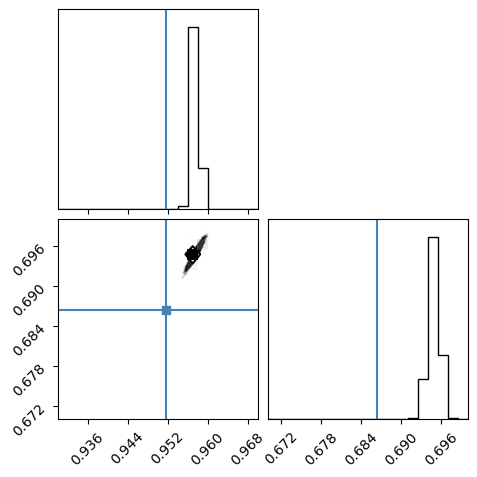

In [77]:
figure = corner.corner(
    samples_main[:,[-1,-2]],
    plot_contours=True,
    truths = [Mf_0, chif_mag_0],
    range=[[0.93, 0.97], [0.67, 0.7]],
)